# COVID-19 - Data Exploration Tutorial with Python and SQL

Stephen Shepherd, 2020-04-04

You're in a Jupyter Notebook.  It's essentially a private webpage your computer is running that allows you to run and see results from python code in interactive, organized blocks.

This is a 'Markdown' cell for comments (you can change a cell to a markdown cell using the dropdown menu above).  To run a 'code' cell, place your cursor in the cell and hit Shift+Enter, or click the play button to the left of the cell.  For keyboard shortcuts, click the keyboard button on the top bar.

#### Now that you have this notebook up and running, let's explore some data in a notebook

##### Steps:

1) Import useful packages

2) Connect to recent Johns Hopkins University COVID-19 data

3) Basic time series analysis by country and state

4) Case-level statistical analysis of demographic factors impacting survival rates

5) Social distancing impact simulation

6) Try some queries yourself

## 1) Imports and Configuration

First, we need to import some 'packages' we'll use on the data.  If this is foreign, don't worry, it's not crucial to understand.

Run the code cells yourself as we go:

In [1]:
### Quickly install pandasql, a package allowing you to run SQL queries on a local file
#! pip install pandasql

In [2]:
import pandas as pd   ## pandas dataframe package
import pandasql as ps ## pandasql for running SQL on data in a pandas dataframe
import numpy as np    ## numpy is a handy package for handling numerical data
import seaborn as sns ## seaborn is a pretty plotting package

## pandas display options
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_colwidth", 100)

## display plots inline in the notebook
%matplotlib inline

C:\Users\sshepherd\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2): Access and Read the COVID-19 data from Johns Hopkins University

JHU posts data daily to the Github repo https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data.  I assume this powers their dashboard here: https://coronavirus.jhu.edu/map.html

A company named Starschema partnered with Snowflake Computing to clean and unify the various data files. Continuously updated .csv for geography time series data is published here: https://s3-us-west-1.amazonaws.com/starschema.covid/JHU_COVID-19.csv

Conveniently, the pandas package we imported can read the .csv file into a table, directly from the link!  Or if you prefer to download the file to your computer first, you can pass pandas the path below like pd.read_csv('C://Users/sshepherd/Desktop/file.csv')

In [3]:
## Read .csv data from the URL in the time series folder
## could take 1-2 minutes depending on your connection
data = pd.read_csv('https://s3-us-west-1.amazonaws.com/starschema.covid/JHU_COVID-19.csv')

print(data.shape) ## gets # of rows, columns
data.head(2) ## displays passed # of rows

(147314, 13)


C:\Users\sshepherd\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Country/Region,Province/State,County,FIPS,Date,Case_Type,Cases,Long,Lat,ISO3166-1,ISO3166-2,Difference,Last_Update_Date
0,Afghanistan,NaN,NaN,NaN,2020-01-22 00:00:00.000000,Confirmed,0,65.0,33.0,AF,NaN,NaN,2020-04-04 13:19:45.015875
1,Afghanistan,NaN,NaN,NaN,2020-01-23 00:00:00.000000,Confirmed,0,65.0,33.0,AF,NaN,0.0,2020-04-04 13:19:45.015875


This loaded the .csv file into your computer's RAM memory as a pandas dataframe **object** named 'data' in the notebook.  This is a reasonable way to interact with small to medium size datasets that will fit in your computer's RAM.

#### Some small data cleaning you don't need to worry about

In [4]:
## convert columns to lowercase, replace '/' with '_'
[data.rename(columns={c: c.lower().replace('/','_')}, inplace=True) for c in data.columns]

## standardize date field types
for C in ['date','last_update_date']:
    data[C] = pd.to_datetime(data[C]).astype(str)
    
data.sort_values(by=['case_type','date','country_region'], ascending=False, inplace=True)

## 3) Basic time series analysis

#### A simple table preview function

Before we start, we often need to orient ourselves with a table.  Above, we got the shape (rows, columns) and displayed the first row for the table.  Let's write a function to do that with less typing:

In [5]:
def preview(dataframe, num_rows=1):
    '''Prints shape of dataframe and displays passed number of rows, defaulting to 1 row if not passed'''
    print("Rows: {0}, Columns: {1}".format(dataframe.shape[0], dataframe.shape[1]))
    display(dataframe.head(num_rows))

So we're dealing with a table with ~140k rows and 5 columns (as of 2020-04-03)

### What date range does our data cover, and how many geographies are included so far?

For this, let's run our first SQL query.  **Why SQL?**   SQL arguably the most common tool for working with tabular data at scale across many platform and has remained a constant force in analytics over time.  SQL is supported, sometimes behind the scenes, in most software products and data platforms.

pandasql detects the *objects* in the notebook, so if you have a pandas dateframe *object* named 'data', for example, you can use it in the FROM statement

For more SQL info, I recommend: https://www.datacamp.com/courses/tech:sql

In [6]:
query = '''
    SELECT
        COUNT(DISTINCT(country_region)),
        COUNT(DISTINCT(province_state)),
        MIN(date),
        MAX(date)
    FROM
        data
'''

ps.sqldf(query)

,COUNT(DISTINCT(country_region)),COUNT(DISTINCT(province_state)),MIN(date),MAX(date)
0,196,143,2020-01-22,2020-04-03


So we're dealing with data starting 2020-01-22, across 196 countries so far.

**How it worked:** The SQL query text ran on the 'data' dataframe we made above via ps.sqldf() function, and returned another dataframe as the result, which was displayed by the notebook.  The SQL query calculated some summary metrics over the whole table.

#### Let's make another quick function to run a query

In [7]:
def runquery(query):
    return ps.sqldf(query)

### How many total confirmed cases and deaths have there been?

Instead of pulling summary metrics over the whole table, lets isolate a specific day.  This dataset is CUMULATIVE counts over time by geography, so summing all cases over all dates will duplicate counts.  For that reason, let's filter for a specific date to get the cumulative totals.

Let's use a **WHERE** clause to filter for a specific date:

In [8]:
runquery(
    '''
    SELECT
        case_type,
        SUM(cases) AS number_confirmed,
        MAX(date) AS as_of_date
    FROM
        data
    WHERE
        date = '2020-04-03'
    GROUP BY
        case_type
    '''
)

,case_type,number_confirmed,as_of_date
0,Confirmed,1095765,2020-04-03
1,Deaths,58784,2020-04-03


### What do confirmed cases over time look like?

Anytime you'd like to aggregate data by a dimension in SQL, you perform an aggregate function in the SELECT statement (SUM() here), and you add a **GROUP BY** to list the dimensions you'd like to aggregate by (case_type here). You can specify the columns to GROUP BY by including the # from the order in which they appear in the SELECT statement, or you can name them.

Let's group by date now and store the result in a variable called 'result' to use later.  Let's also filter the cases to be 'Confirmed' type.

In [9]:
result = runquery(
    '''
    SELECT
        date,
        SUM(cases) AS quantity
    FROM
        data
    WHERE
        case_type = 'Confirmed'
    GROUP BY
        1
    '''
)

display(result)

,date,quantity
0,2020-01-22,555
1,2020-01-23,653
2,2020-01-24,941
3,2020-01-25,1434
4,2020-01-26,2118
5,2020-01-27,2927
6,2020-01-28,5578
7,2020-01-29,6166
8,2020-01-30,8234
9,2020-01-31,9927


#### A picture is often interpreted faster:

We can use the 'result' dataframe's (from above) plot method.  For more info, see: https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html

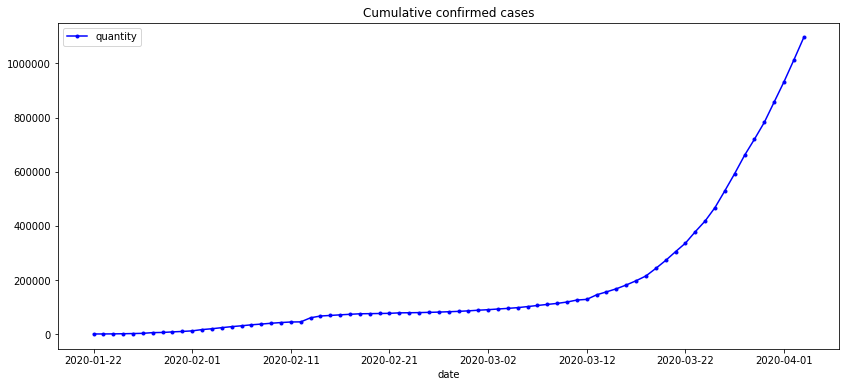

In [10]:
result.set_index('date').plot(kind='line', style='.-', color='blue', figsize=[14,6], title='Cumulative confirmed cases')

#### What if we wanted to write out our result table to a file?

In [11]:
result.to_csv("cumulative_confirmed_cases.csv", index=False)

### What about the resolved cases?

The .plot() method can draw different lines per dimension if they're broken out as columns (eg. pivoted).  So below, we'll aggregate by both case_type and date as a dimension, and the use pandas' **pivot** method to break out the case_type data column-wise.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html

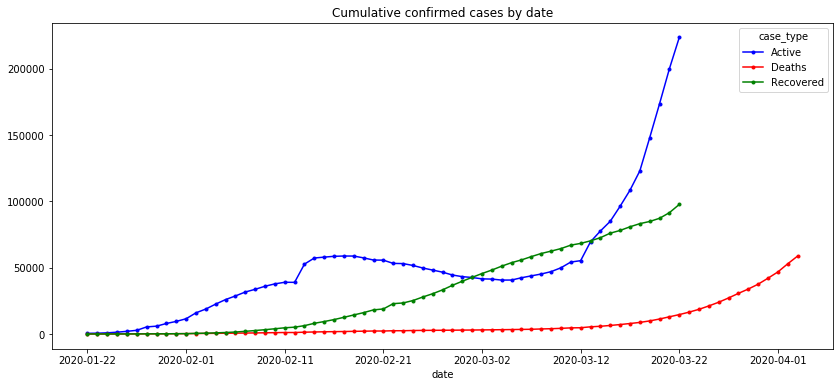

In [12]:
date_type = runquery(
    '''
    SELECT
        case_type,
        date,
        SUM(cases) AS quantity
    FROM
        data
    WHERE
        case_type IN ('Active','Deaths','Recovered')
    GROUP BY
        1,2
    '''
)

(
    date_type
    .pivot(index='date', columns='case_type', values='quantity') ## https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html
    .plot(kind='line', style='.-', figsize=[14,6], title=f'Cumulative confirmed cases by date', color=['blue','red','green'])
)

It looks like the Active and Recovered case types lag ~1 week behind the Confirmed and Death case counts.  There are a few reasons that could be why this may be the case.

### How about deaths by country?

Let's group by country and date now

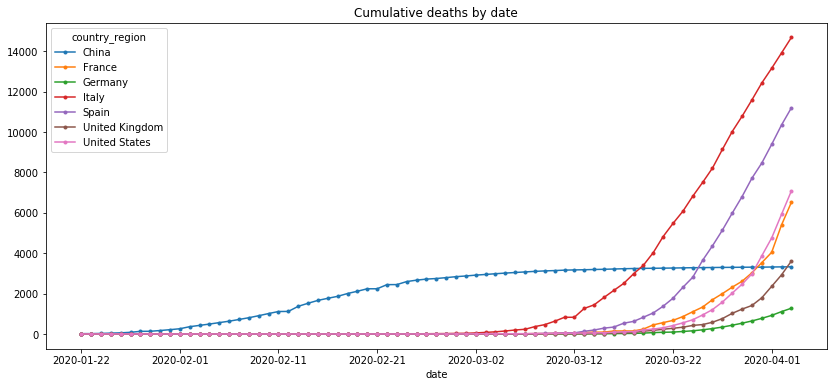

In [13]:
country_date_deaths = runquery(
    '''
    SELECT
        country_region,
        date,
        SUM(cases) AS deaths
    FROM
        data
    WHERE
        case_type = 'Deaths'
        AND country_region IN ('China','Italy','Spain','Germany','France','United Kingdom','United States')
    GROUP BY
        1,2
    '''
)

(
    country_date_deaths
    .pivot(index='date', columns='country_region', values='deaths')
    .plot(kind='line', style='.-', figsize=[14,6], title=f'Cumulative deaths by date')
)

China seems to have halted the growth of cases, perhaps due to their previous experience with SARS.  Some are saying that China underreported cases though, citing year-over-year monthly death increases that greatly surpass their COVID death counts.

### How about change in deaths daily by country?

A day-over-day change can let us 'zoom in' on the rate at which these lines are growing (or hopefully decreasing).

Below, we use SQL's **LAG** function over a **WINDOW** spec that orders the data by country and date, to calculate the daily change row-wise (eg. difference from one row to the next).  The query is run on the above's 'country_date_deaths' dataframe object.

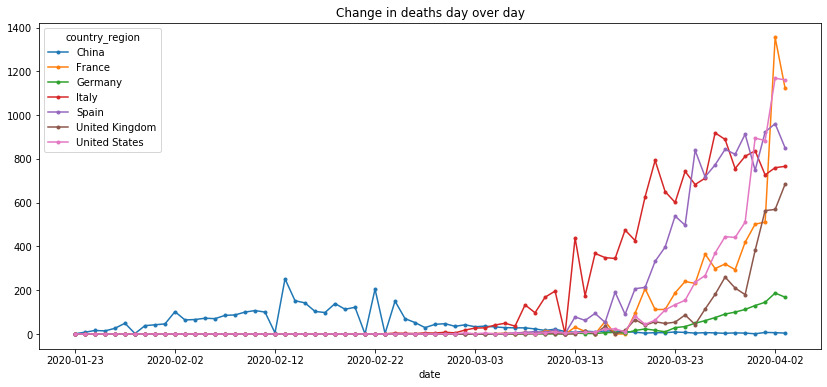

In [14]:
result = runquery('''
    SELECT
        country_region, date, deaths,
        deaths - LAG(deaths) OVER (PARTITION BY country_region ORDER BY date) AS daily_change
    FROM
        country_date_deaths
    '''
)

(
    result
    .query("date >= '2020-01-23'")
    .pivot_table(index='date', columns='country_region', values='daily_change', aggfunc='sum') ## Google 'pandas pivot table'
    .plot(kind='line', style='.-', figsize=[14,6], title=f'Change in deaths day over day')
)

Italy and Spain's daily increases seem to be stabilizing a little, but the U.S. and France are taking off.  That being said, it's important to *remember that the U.S. has a larger population that many countries*.  Perhaps we should normalize on that to compare apples to apples.

### Can we normalize on population?

Let's create a dataframe ourselves with some population counts.  Below, we do this via the pd.DataFrame constructor passing in a dictionary {} of data keyed by column name, containing the list [] elements we want to place in each column.

In [15]:
## Creating a dataframe with 2 columns from 2 lists of values manually input
## data source: https://www.worldometers.info/world-population/population-by-country/
country_pops = pd.DataFrame(
    data = {
        'country_region': ['China','Italy','Spain','Sweden','Germany','France','United States','United Kingdom',
                           'California','New York','Washington','District of Columbia'],
        'population'    : [1439000000, 60461000, 46754000,10099000,83783000,65273000,331002000,67886000,
                           39747267,19491339,7797095,720687]
    }
).sort_values(by="population", ascending=False)

country_pops

,country_region,population
0,China,1439000000
6,United States,331002000
4,Germany,83783000
7,United Kingdom,67886000
5,France,65273000
1,Italy,60461000
2,Spain,46754000
8,California,39747267
9,New York,19491339
3,Sweden,10099000


### Join population data to the COVID data to get change in daily deaths per capita

The **INNER JOIN** clause merges our COVID data with the country_pops table we made above, using country name as the common.  Similar to a VLOOKUP in Excel.  We bring in country_pops' 'population' column, and use it in some of the SELECT calculations.

Let's calculate a change in daily death rate *per million citizens*.

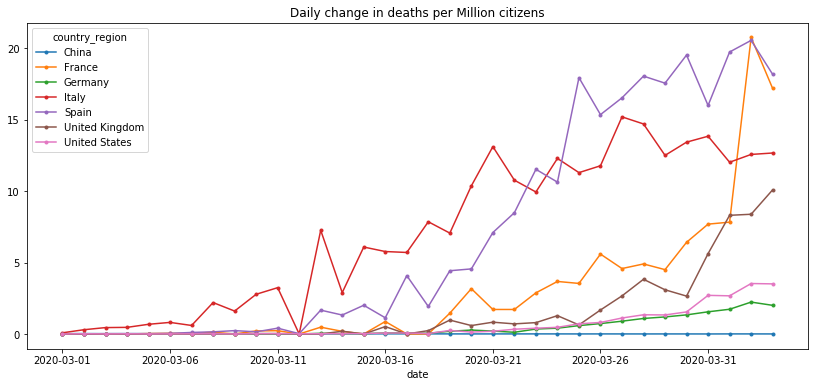

In [16]:
result = runquery('''
    SELECT
        country_region, date, deaths, population,
        deaths / CAST(population AS FLOAT) * 1000000 AS deaths_per_1mm_citizens,
        (deaths - LAG(deaths) OVER (ORDER BY country_region, date)) / CAST(population AS FLOAT) * 1000000 AS daily_change_per_1mm_citizens
    FROM
        country_date_deaths
        INNER JOIN country_pops USING(country_region)
    '''
)

(
    result
    .query("date >= '2020-03-01'")
    .pivot(index='date', columns='country_region', values='daily_change_per_1mm_citizens') ## Google 'pandas pivot table'
    .plot(kind='line', style='.-', figsize=[14,6], title=f'Daily change in deaths per Million citizens')
)

Italy, France and Spain seem to be having a difficult time.

### How do things look by state within the U.S.?

Here we read a file of state populations from census.gov, and join it to the COVID data similar to how we brought in country population data above.

I also add a **HAVING** statement, which filters the aggregate SUM(cases) values AFTER the aggregation and GROUP BY are performed, as opposed to a WHERE which just filters the FROM table's original values.  This keeps states' dates with total deaths >= 50

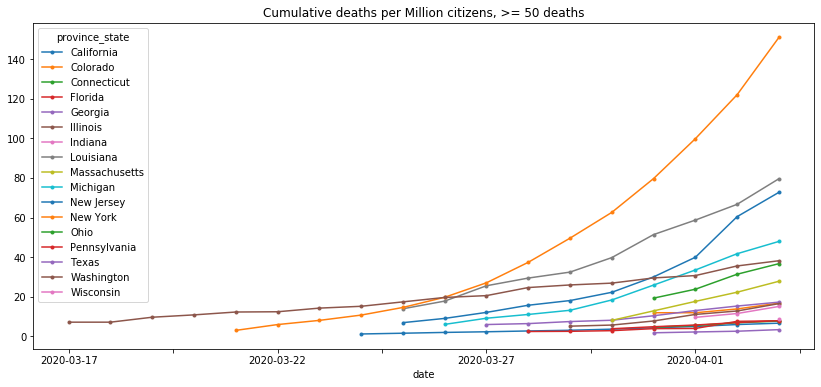

In [17]:
us_state_pops = (
    pd.read_csv(
    'https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/state/detail/SCPRC-EST2019-18+POP-RES.csv')
    [['NAME','POPESTIMATE2019']]
)

state_date_deaths = runquery(
    '''
    SELECT
        province_state,
        date,
        POPESTIMATE2019 AS population,
        SUM(cases) AS deaths
    FROM
        data
        INNER JOIN us_state_pops ON(us_state_pops.NAME = data.province_state)
    WHERE
        case_type = 'Deaths'
        AND country_region IN ('United States')
        AND date >= '2020-03-01'
    GROUP BY
        1,2,3
    HAVING
        deaths >= 50
    '''
)

## Have pandas calculate deaths per million
state_date_deaths['deaths_per_million_citizens'] = state_date_deaths.deaths / state_date_deaths.population * 1000000

(
    state_date_deaths
    .pivot(index='date', columns='province_state', values='deaths_per_million_citizens') ## Google 'pandas pivot table'
    .plot(kind='line', style='.-', figsize=[14,6], title=f'Cumulative deaths per Million citizens, >= 50 deaths')
)

Washington state's incidence of deaths was about as high as New York's 2020-03-25 value one week before that, but it's rate of change appears 'flatter.'  Correlated factors could include population density, travel, events/gatherings, etc.

Many states appear to just be starting their upward climb.

### What do things look like in my area?

For this, we'll use SQL's **WHERE** qualifier to filter for a geography on the daily_summaries dataset.   We'll pass in the country, state and start_date variables into the query string via formatting.  You can **format** variables into a string by placing the 'f' in front of the query quotes, and putting the variable name in curly braces eg. '{country}' inside the query.  This can be a great way to automate queries and pass results from one query into another.

We'll also use Pandas' PIVOT method to quickly reshape the data.

In [18]:
## Enter the values you'd like to filter for
country    = 'United States'
state      = 'Georgia'
start_date = '2020-03-01'

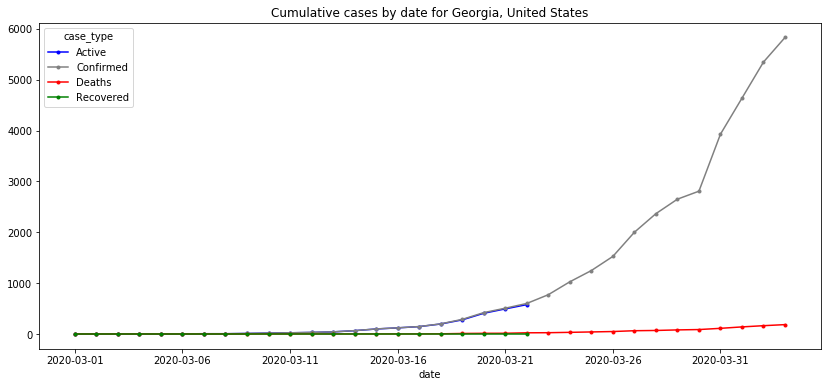

In [19]:
## By putting a 'f' in front of the quotes, we can 'format-in' country/state into the string using curly braces
result = runquery(
    f'''
    SELECT
        case_type, country_region, province_state, date,
        SUM(cases) AS cases
    FROM
        data
    WHERE
        country_region = '{country}'
        AND province_state = '{state}'
        AND date >= '{start_date}'
    GROUP BY
        1,2,3,4
    '''
)

(
    result
    .pivot(index='date', columns='case_type', values='cases')
    .plot(kind='line', style='.-', figsize=[14,6], title=f'Cumulative cases by date for {state}, {country}', color=['blue','gray','red','green'])
)

### Country/State comparison dashboard

I'd like to compare some countries alongside some states.  For this, I'll **UNION** (eg. stack) two tables on top of eachother: one for countries, one for states.  I also use a **WITH** statement to create a temporary table 'geo_cases', that I can use in another subsequent query.  This can be a good way to cleanly define and organize intermediate tables you need.

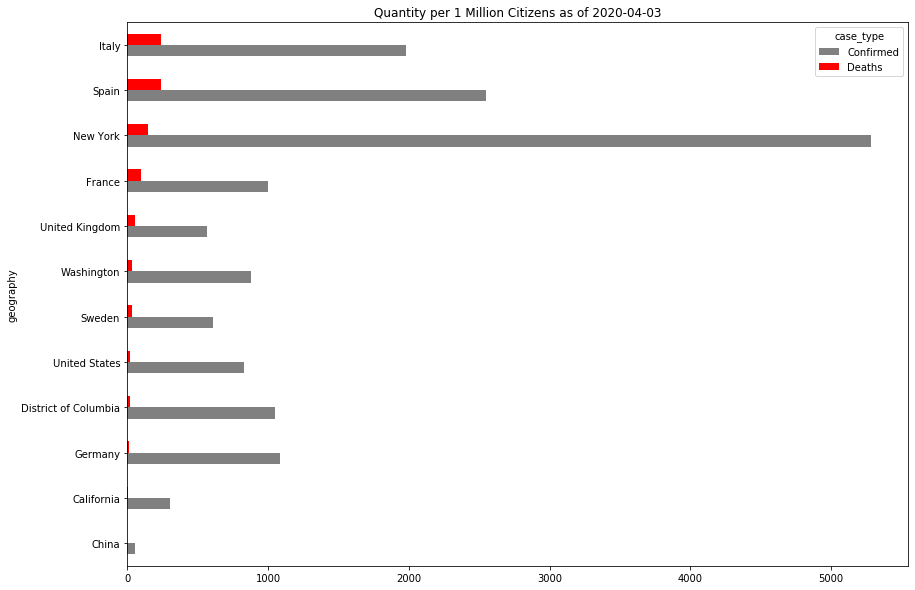

In [20]:
date = max(data.date)

deaths_per_capita = runquery(f'''
WITH geo_cases AS (
    SELECT
        country_region AS geography,
        case_type,
        SUM(cases) AS cases
    FROM
        data
    WHERE
        date = '{date}'
        AND country_region IN ('China','Italy','Spain','Sweden','Germany','France','United States','United Kingdom')
    GROUP BY
        1,2

UNION
    
    SELECT
        province_state AS geography,
        case_type,
        SUM(cases) AS cases
    FROM
        data
    WHERE
        date = '{date}'
        AND province_state IN ('New York','California','Washington','District of Columbia')
    GROUP BY
        1,2
)

SELECT
    geography,
    case_type,
    cases,
    population,
    ROUND(cases / CAST(population AS FLOAT) * 1000000) AS quantity_per_million_citizens
FROM
    geo_cases
    INNER JOIN country_pops ON(country_pops.country_region = geo_cases.geography)
ORDER BY
    case_type DESC, quantity_per_million_citizens DESC
    
''')

(
    deaths_per_capita
    .pivot(index='geography', columns='case_type', values='quantity_per_million_citizens')
    .sort_values(by='Deaths', ascending=True)
    .plot(kind='barh', style='.-', figsize=[14,10], title=f'Quantity per 1 Million Citizens as of {date}', color=['gray','red'])
)

#### Let's view as a table

In [21]:
deaths_per_capita

,geography,case_type,cases,population,quantity_per_million_citizens
0,Italy,Deaths,14681,60461000,243.0
1,Spain,Deaths,11198,46754000,240.0
2,New York,Deaths,2935,19491339,151.0
3,France,Deaths,6520,65273000,100.0
4,United Kingdom,Deaths,3611,67886000,53.0
5,Washington,Deaths,291,7797095,37.0
6,Sweden,Deaths,358,10099000,35.0
7,United States,Deaths,7084,331002000,21.0
8,District of Columbia,Deaths,15,720687,21.0
9,Germany,Deaths,1275,83783000,15.0


So, as of 4/3/2020, Italy tops the list for % of citizens killed at **230** deaths per million citizens.  The U.S. is currently at **18** deaths per million citizens.

### Rudimentary projection for the U.S.

Let's normalize each curve to start for each country on the day the country reached 1 death per million citizens.  That way, we can see how the U.S. might look if we follow the same curve.  I do this using the RANK() OVER (PARTITION BY country_region ORDER BY date) AS days_since_start calculation, combined with the WHERE deaths_per_1mm_citizens >= 1.

I'm using Italy and Spain as comparisons because they are also Western and fairly far ahead of the U.S., but these countries have major differences that would need to be accounted for in a more serious setting.

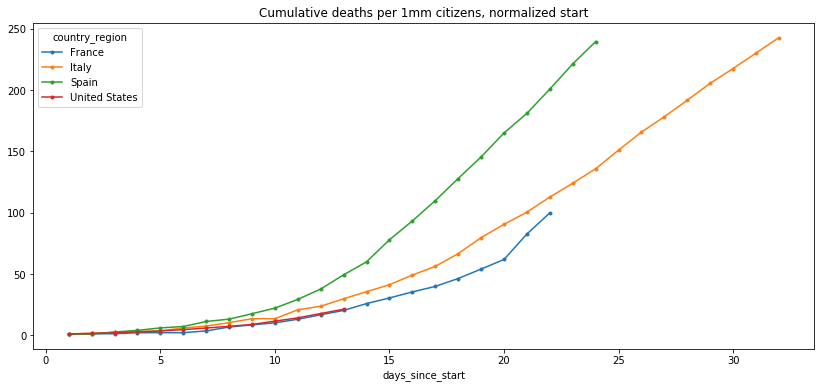

In [22]:
start_deaths_per_1mm = 1
countries = "'Italy','Spain','United States','France'"

shifted = runquery(f'''
    WITH country_deaths AS (
        SELECT country_region, date, SUM(cases) AS deaths
        FROM data
        WHERE country_region IN ({countries})
        AND case_type = 'Deaths'
        GROUP BY 1, 2
    )
    
    SELECT
        country_region, population, date,
        RANK() OVER (PARTITION BY country_region ORDER BY date) AS days_since_start,
        deaths, deaths / CAST(population AS FLOAT) * 1000000 AS deaths_per_1mm_citizens
    FROM
        country_deaths
        INNER JOIN country_pops USING(country_region)
    WHERE
        deaths_per_1mm_citizens >= {start_deaths_per_1mm}
    ORDER BY
        country_region, date
''')

(
    shifted
    .pivot(index='days_since_start', columns='country_region', values='deaths_per_1mm_citizens')
    .plot(kind='line', style='.-', figsize=[14,6], title='Cumulative deaths per 1mm citizens, normalized start')
)

So if the U.S. continues following a slightly more optimistic curve than Italy, we'll be at *200 deaths per million citizens in 3 weeks*.  So that would be this many total deaths by then:

In [23]:
200 * 327.2 ## deaths per 1mm citizens x citizens in millions

65440.0

What if we reached 4x Italy's 200 deaths per million citizens at some point?

In [24]:
4 * 200 * 327.2  ## multiplier x deaths per 1mm citizens x citizens in millions

261760.0

When will this curve peak, and will the following decline have a very long tail that accumulates few daily deaths but over many days?  Will there be another curve the follows?  How will this all compare to healthcare capacity by geography?  These are questions that epidemiologists try to answer by combining these data management practices introduced in this notebook with statistics & mathematics and other fields.

See: https://covid19.healthdata.org/projections

## 4) Case-level ruidmentary statistical analysis

I found some case-level data on Kaggle that includes patient-level demographic info:
https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset

We can use this to explore how age and gender impact the survival rate.

In [27]:
##                      (you'll need to download the file above and load it from your computer similar to the below)
case_level = pd.read_csv("C:/Users/sshepherd/Downloads/COVID19_line_list_data.csv")

preview(case_level, 3)

Rows: 1085, Columns: 27


,id,case_in_country,reporting date,Unnamed: 3,summary,location,country,gender,age,symptom_onset,If_onset_approximated,hosp_visit_date,exposure_start,exposure_end,visiting Wuhan,from Wuhan,death,recovered,symptom,source,link,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,1,NaN,1/20/2020,NaN,"First confirmed imported COVID-19 pneumonia patient in Shenzhen (from Wuhan): male, 66, shenzhen...","Shenzhen, Guangdong",China,male,66.0,01/03/20,0.0,01/11/20,12/29/2019,01/04/20,1,0.0,0,0,NaN,Shenzhen Municipal Health Commission,http://wjw.sz.gov.cn/wzx/202001/t20200120_18987787.htm,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,1/20/2020,NaN,"First confirmed imported COVID-19 pneumonia patient in Shanghai (from Wuhan): female, 56, Wuhan ...",Shanghai,China,female,56.0,1/15/2020,0.0,1/15/2020,NaN,01/12/20,0,1.0,0,0,NaN,Official Weibo of Shanghai Municipal Health Commission,https://www.weibo.com/2372649470/IqogQhgfa?from=page_1001062372649470_profile&wvr=6&mod=weibotim...,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,1/21/2020,NaN,"First confirmed imported cases in Zhejiang: patient is male, 46, lives in Wuhan, self-driving fr...",Zhejiang,China,male,46.0,01/04/20,0.0,1/17/2020,NaN,01/03/20,0,1.0,0,0,NaN,Health Commission of Zhejiang Province,http://www.zjwjw.gov.cn/art/2020/1/21/art_1202101_41786033.html,NaN,NaN,NaN,NaN,NaN,NaN


#### Let's do a little cleaning and calculate the fatality rate

I'll focus on age and gender as predictors to keep things intuitive, but there are some other interesting fields in this dataset too like date of symptom onset and date of hospital visit.

In [28]:
for_tree = runquery('''
    SELECT
        CAST(death AS INT) AS death,
        ABS(death - 1) AS survived,
        CASE WHEN gender = 'male' THEN 1 ELSE 0 END AS gender_male,
        CAST(ROUND(age) AS INT) AS age
    FROM
        case_level
    WHERE
        LENGTH(gender) > 0
        AND age > 0
        AND LENGTH(death) = 1
''')

preview(for_tree)

print(np.round(for_tree.death.mean(), 4), 'died')
print(np.round(for_tree.survived.mean(), 4), 'survived')

Rows: 809, Columns: 4


,death,survived,gender_male,age
0,0,1,1,66


0.0519 died
0.9481 survived


So we isolated 809 case rows with a fatality rate of 5.2%

Let's examine the distribution of patients over age by those that died (red) and those that survived (blue):

deaths (red) survivals (blue) over age


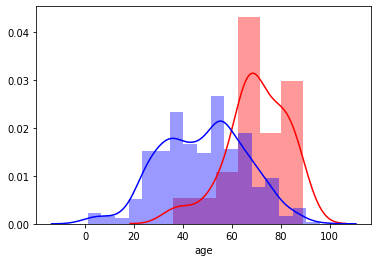

In [29]:
print("deaths (red) survivals (blue) over age")
sns.distplot(for_tree.query("death == 1").age, color='red')
sns.distplot(for_tree.query("death == 0").age, color='blue')

It looks like age might be correlated with outcome as many have been reporting.  Notice that very few patients in general in this data are under age 30.

### Try a simple Decision Tree Classifier to learn factors that impacted whether the patient lived

This iteratively slices the data across the provided dimensions to try and separate out patients that lived from those that did not survive.  Trees can be very powerful, sometimes too powerful in that they can memorize sample data and 'overfit' if grown too deep.  We'll keep our tree fairly short for exploratory purposes.

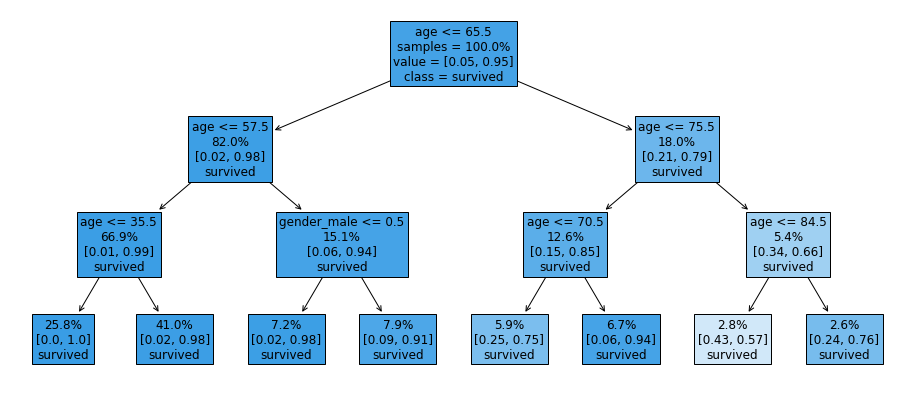

In [30]:
from sklearn import tree  ## sklearn is a machine learning package for python
## Plotting packages
import graphviz
import matplotlib.pyplot as plt

## target and predictor variables
y = for_tree.survived
X = for_tree[['gender_male','age']]

## Decision Tree classifier object
clf = tree.DecisionTreeClassifier(
    max_depth=3,
    min_samples_split=20,
    min_samples_leaf=20
)

## Fit the model
fitted_tree = clf.fit(X,y)

## Plot settings
fig, ax = plt.subplots(figsize=(16, 7))

## Plot the tree
ignore = tree.plot_tree(
    fitted_tree,
    class_names=['death','survived'],
    feature_names=X.columns,
    impurity=False,
    proportion=True,
    label='root',
    filled=True,
    precision=2,
    fontsize=12
)

I'm examining the second value in each set of brackets in each node.  The % value above that shows what % of total cases represented.

#### Following the RIGHTWARD (condition of node being *false*) path from the root we see:
* Survival rate goes from 95% in general to 79% for patients over 65 years old
* That decreases further to 66% for patients over 75

#### Following the LEFTWARD (condition of node being *true*) path from the root we see:
* Survival rate goes from 95% in general to 98% for patients under 65 years old
* But, if patient is aged 57 to 65, the rate goes back to 94%
* Of those, if the patient is male, the rate goes down to 90%

100% of patients under the age of 35 in this particular group survived (bottom left most node).  This sample is of course subject to many factors that may or may not be present in your case.  For example, this group of patients may have been treated in a healthcare system that was not yet strained, and may have skewed healthier than the avg person.

Of course, this sample might also be biased in favor of more ominous cases as they appear to have been hospitalized.

## 5) Simple social distancing simulation

Assuming avg of **4** daily physical interactions per person

In [31]:
num_infected           = 1
avg_daily_interactions = 4
infection_rate         = .5
print(f"starting infections: {int(np.round(num_infected)):,}")

## simulate 20 days
for i in range(10):
    new_infections = np.round(num_infected * avg_daily_interactions * infection_rate)
    num_infected  += np.round(new_infections)
    print(f"                                  new infections: {int(np.round(new_infections)):,}")
    print(f"day: {str(i + 1).ljust(2)}, number infected: {int(np.round(num_infected)):,}")

starting infections: 1
                                  new infections: 2
day: 1 , number infected: 3
                                  new infections: 6
day: 2 , number infected: 9
                                  new infections: 18
day: 3 , number infected: 27
                                  new infections: 54
day: 4 , number infected: 81
                                  new infections: 162
day: 5 , number infected: 243
                                  new infections: 486
day: 6 , number infected: 729
                                  new infections: 1,458
day: 7 , number infected: 2,187
                                  new infections: 4,374
day: 8 , number infected: 6,561
                                  new infections: 13,122
day: 9 , number infected: 19,683
                                  new infections: 39,366
day: 10, number infected: 59,049


Assuming avg of **3** daily physical interactions per person (reduction of 1 interaction per person)

In [32]:
num_infected           = 1
avg_daily_interactions = 3
infection_rate         = .5
print(f"starting infections: {int(np.round(num_infected)):,}")

## simulate 20 days
for i in range(10):
    new_infections = np.round(num_infected * avg_daily_interactions * infection_rate)
    num_infected  += np.round(new_infections)
    print(f"                                  new infections: {int(np.round(new_infections)):,}")
    print(f"day: {str(i + 1).ljust(2)}, number infected: {int(np.round(num_infected)):,}")

starting infections: 1
                                  new infections: 2
day: 1 , number infected: 3
                                  new infections: 4
day: 2 , number infected: 7
                                  new infections: 10
day: 3 , number infected: 17
                                  new infections: 26
day: 4 , number infected: 43
                                  new infections: 64
day: 5 , number infected: 107
                                  new infections: 160
day: 6 , number infected: 267
                                  new infections: 400
day: 7 , number infected: 667
                                  new infections: 1,000
day: 8 , number infected: 1,667
                                  new infections: 2,500
day: 9 , number infected: 4,167
                                  new infections: 6,250
day: 10, number infected: 10,417


With a 25% reduction in physical interactions daily, # of infected by day 10 is reduced by 85%

## 6) Try some queries yourself

Now that you've seen a few examples above, how would you slice the data?

FROM **data** will give you the geography cumulative time series data

FROM **case_level** will give you the case-level data, which could use some cleaning.

In [34]:
query = '''

SELECT ...

'''

result = runquery(query)

display(result)

# END